# 数据导入

In [ ]:
# 导入数据集合


# AutoEncoder

In [1]:
# coding:utf-8
import numpy as np
import tensorflow as tf
from sklearn.datasets import load_iris, load_digits
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

'''
author: heucoder
email: 812860165@qq.com
date: 2019.6.13
'''

def reset_graph(seed=42):
    '''
    reset deafault graph
    :param seed: random seed
    :return:
    '''
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def AutoEncoder(data,
                hidden_layers = None,
                noise = 0,
                drop_rate = 0,
                n_epochs = 301,
                learning_rate = 0.01,
                optimizer_type = 'adam',
                verbose = 1):
    '''

    :param data: (n_samples, n_features)
    :param hidden_layers: list hidden layers units num
    :param noise: normal noise
    :param drop_rate:
    :param n_epochs:
    :param learning_rate:
    :param optimizer_type:
    :param verbose:
    :return:
    '''


    reset_graph()
    n_inputs = data.shape[1]
    n_outputs = n_inputs

    X = tf.placeholder(tf.float32, shape=[None, n_inputs])

    # add noise
    X_noise = X + noise * tf.random_normal(tf.shape(X))

    # dropout
    training = tf.placeholder_with_default(False, shape=(), name = "training")
    X_drop = tf.layers.dropout(X_noise, drop_rate, training=training)

    hiddens = [X_drop]
    for i in range(len(hidden_layers)):
        n_layer = hidden_layers[i]
        hidden = tf.layers.dense(hiddens[i], n_layer, )
        hiddens.append(hidden)

    outputs = tf.layers.dense(hiddens[-1], n_outputs)
    hiddens.append(outputs)

    reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

    if optimizer_type == 'adam':
        optimizer = tf.train.AdamOptimizer(learning_rate)
    else:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)

    training_op = optimizer.minimize(reconstruction_loss)

    init = tf.global_variables_initializer()

    # coding layer
    codings = hiddens[len(hiddens)//2]

    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            sess.run(training_op, feed_dict={X: data, training: True})
            loss_train = reconstruction_loss.eval(feed_dict={X: data})
            if epoch % 100 == 0 and verbose:
                print("\r{}".format(epoch), "Train MSE:", loss_train)
        data_ndim = codings.eval(feed_dict={X: data})

    return data_ndim

if __name__ == '__main__':
    iris = load_digits()
    X = iris.data
    Y = iris.target
    data_1 = AutoEncoder(X, [2], learning_rate = 0.2,  n_epochs = 1000)

    data_2 = PCA(n_components=2).fit_transform(X)

    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.title("my_AutoEncoder")
    plt.scatter(data_1[:, 0], data_1[:, 1], c = Y)

    plt.subplot(122)
    plt.title("sklearn_PCA")
    plt.scatter(data_2[:, 0], data_2[:, 1], c = Y)
    plt.savefig("AutoEncoder.png")
    plt.show()

C:\anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


0 Train MSE: 570.36755
100 Train MSE: 17.716026
200 Train MSE: 16.092857
300 Train MSE: 15.40169
400 Train MSE: 14.823234
500 Train MSE: 14.175096
600 Train MSE: 13.79578
700 Train MSE: 13.642618
800 Train MSE: 13.560842
900 Train MSE: 13.507963


In [ ]:
# ICA

In [3]:
# coding:utf-8
# 代码来源:https://blog.csdn.net/lizhe_dashuju/article/details/50263339


# FastICA
import math
import random
import matplotlib.pyplot as plt
from numpy import *

n_components = 2

def f1(x, period = 4):
    return 0.5*(x-math.floor(x/period)*period)

def create_data():
    #data number
    n = 500
    #data time
    T = [0.1*xi for xi in range(0, n)]
    #source
    S = array([[sin(xi)  for xi in T], [f1(xi) for xi in T]], float32)
    #mix matrix
    A = array([[0.8, 0.2], [-0.3, -0.7]], float32)
    return T, S, dot(A, S)

def whiten(X):
    #zero mean
    X_mean = X.mean(axis=-1)
    X -= X_mean[:, newaxis]
    #whiten
    A = dot(X, X.transpose())
    D , E = linalg.eig(A)
    D2 = linalg.inv(array([[D[0], 0.0], [0.0, D[1]]], float32))
    D2[0,0] = sqrt(D2[0,0]); D2[1,1] = sqrt(D2[1,1])
    V = dot(D2, E.transpose())
    return dot(V, X), V

def _logcosh(x, fun_args=None, alpha = 1):
    gx = tanh(alpha * x, x); g_x = gx ** 2; g_x -= 1.; g_x *= -alpha
    return gx, g_x.mean(axis=-1)

def do_decorrelation(W):
    #black magic
    s, u = linalg.eigh(dot(W, W.T))
    return dot(dot(u * (1. / sqrt(s)), u.T), W)

def do_fastica(X):
    n, m = X.shape; p = float(m); g = _logcosh
    #black magic
    X *= sqrt(X.shape[1])
    #create w
    W = ones((n,n), float32)
    for i in range(n): 
        for j in range(i):
            W[i,j] = random.random()

    #compute W
    maxIter = 200
    for ii in range(maxIter):
        gwtx, g_wtx = g(dot(W, X))
        W1 = do_decorrelation(dot(gwtx, X.T) / p - g_wtx[:, newaxis] * W)
        lim = max( abs(abs(diag(dot(W1, W.T))) - 1) )
        W = W1
        if lim < 0.0001:
            break
    return W

def show_data(T, S):
    plt.plot(T, [S[0,i] for i in range(S.shape[1])], marker="*")
    plt.plot(T, [S[1,i] for i in range(S.shape[1])], marker="o")
    plt.show()

def main():
    T, S, D = create_data()
    Dwhiten, K = whiten(D)
    W = do_fastica(Dwhiten)
    #Sr: reconstructed source
    Sr = dot(dot(W, K), D)
    show_data(T, D)
    show_data(T, S)
    show_data(T, Sr)
    

In [ ]:
# ISOMAP

In [ ]:
# coding:utf-8
import numpy as np
from sklearn.datasets import make_s_curve
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from mpl_toolkits.mplot3d import Axes3D

def floyd(D,n_neighbors=15):
    Max = np.max(D)*1000
    n1,n2 = D.shape
    k = n_neighbors
    D1 = np.ones((n1,n1))*Max
    D_arg = np.argsort(D,axis=1)
    for i in range(n1):
        D1[i,D_arg[i,0:k+1]] = D[i,D_arg[i,0:k+1]]
    for k in range(n1):
        for i in range(n1):
            for j in range(n1):
                if D1[i,k]+D1[k,j]<D1[i,j]:
                    D1[i,j] = D1[i,k]+D1[k,j]
    return D1

def cal_pairwise_dist(x):
    '''计算pairwise 距离, x是matrix
    (a-b)^2 = a^2 + b^2 - 2*a*b
    '''
    sum_x = np.sum(np.square(x), 1)
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    #返回任意两个点之间距离的平方
    return dist

def my_mds(dist, n_dims):
    # dist (n_samples, n_samples)
    dist = dist**2
    n = dist.shape[0]
    T1 = np.ones((n,n))*np.sum(dist)/n**2
    T2 = np.sum(dist, axis = 1)/n
    T3 = np.sum(dist, axis = 0)/n

    B = -(T1 - T2 - T3 + dist)/2

    eig_val, eig_vector = np.linalg.eig(B)
    index_ = np.argsort(-eig_val)[:n_dims]
    picked_eig_val = eig_val[index_].real
    picked_eig_vector = eig_vector[:, index_]

    return picked_eig_vector*picked_eig_val**(0.5)

def my_Isomap(data,n=2,n_neighbors=30):
    D = cal_pairwise_dist(data)**0.5
    D_floyd=floyd(D, n_neighbors)
    data_n = my_mds(D_floyd, n_dims=n)
    return data_n

def scatter_3d(X, y):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.hot)
    ax.view_init(10, -70)
    ax.set_xlabel("$x_1$", fontsize=18)
    ax.set_ylabel("$x_2$", fontsize=18)
    ax.set_zlabel("$x_3$", fontsize=18)
    plt.show()

if __name__ == '__main__':
    X, Y = make_s_curve(n_samples = 500,
                           noise = 0.1,
                           random_state = 42)

    data_1 = my_Isomap(X, 2, 10)

    data_2 = Isomap(n_neighbors = 10, n_components = 2).fit_transform(X)

    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.title("my_Isomap")
    plt.scatter(data_1[:, 0], data_1[:, 1], c = Y)

    plt.subplot(122)
    plt.title("sklearn_Isomap")
    plt.scatter(data_2[:, 0], data_2[:, 1], c = Y)
    plt.savefig("Isomap.png")
    plt.show()

In [ ]:
# LDA

In [ ]:
#coding:utf-8
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

'''
author: heucoder
email: 812860165@qq.com
date: 2019.6.13
'''


def lda(data, target, n_dim):
    '''
    :param data: (n_samples, n_features)
    :param target: data class
    :param n_dim: target dimension
    :return: (n_samples, n_dims)
    '''

    clusters = np.unique(target)

    if n_dim > len(clusters)-1:
        print("K is too much")
        print("please input again")
        exit(0)

    #within_class scatter matrix
    Sw = np.zeros((data.shape[1],data.shape[1]))
    for i in clusters:
        datai = data[target == i]
        datai = datai-datai.mean(0)
        Swi = np.mat(datai).T*np.mat(datai)
        Sw += Swi

    #between_class scatter matrix
    SB = np.zeros((data.shape[1],data.shape[1]))
    u = data.mean(0)  #所有样本的平均值
    for i in clusters:
        Ni = data[target == i].shape[0]
        ui = data[target == i].mean(0)  #某个类别的平均值
        SBi = Ni*np.mat(ui - u).T*np.mat(ui - u)
        SB += SBi
    S = np.linalg.inv(Sw)*SB
    eigVals,eigVects = np.linalg.eig(S)  #求特征值，特征向量
    eigValInd = np.argsort(eigVals)
    eigValInd = eigValInd[:(-n_dim-1):-1]
    w = eigVects[:,eigValInd]
    data_ndim = np.dot(data, w)

    return data_ndim

if __name__ == '__main__':
    iris = load_iris()
    X = iris.data
    Y = iris.target
    data_1 = lda(X, Y, 2)

    data_2 = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, Y)


    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.title("my_LDA")
    plt.scatter(data_1[:, 0], data_1[:, 1], c = Y)

    plt.subplot(122)
    plt.title("sklearn_LDA")
    plt.scatter(data_2[:, 0], data_2[:, 1], c = Y)
    plt.savefig("LDA.png")
    plt.show()

In [ ]:
# LE

In [ ]:
# coding:utf-8

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from mpl_toolkits.mplot3d import Axes3D

'''
author: heucoder
email: 812860165@qq.com
date: 2019.6.13
'''

def make_swiss_roll(n_samples=100, noise=0.0, random_state=None):
    #Generate a swiss roll dataset.
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))
    x = t * np.cos(t)
    y = 83 * np.random.rand(1, n_samples)
    z = t * np.sin(t)
    X = np.concatenate((x, y, z))
    X += noise * np.random.randn(3, n_samples)
    X = X.T
    t = np.squeeze(t)
    return X, t

def rbf(dist, t = 1.0):
    '''
    rbf kernel function
    '''
    return np.exp(-(dist/t))

def cal_pairwise_dist(x):

    '''计算pairwise 距离, x是matrix
    (a-b)^2 = a^2 + b^2 - 2*a*b
    '''
    sum_x = np.sum(np.square(x), 1)
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    #返回任意两个点之间距离的平方
    return dist

def cal_rbf_dist(data, n_neighbors = 10, t = 1):

    dist = cal_pairwise_dist(data)
    n = dist.shape[0]
    rbf_dist = rbf(dist, t)

    W = np.zeros((n, n))
    for i in range(n):
        index_ = np.argsort(dist[i])[1:1+n_neighbors]
        W[i, index_] = rbf_dist[i, index_]
        W[index_, i] = rbf_dist[index_, i]

    return W

def le(data,
          n_dims = 2,
          n_neighbors = 5, t = 1.0):
    '''

    :param data: (n_samples, n_features)
    :param n_dims: target dim
    :param n_neighbors: k nearest neighbors
    :param t: a param for rbf
    :return:
    '''
    N = data.shape[0]
    W = cal_rbf_dist(data, n_neighbors, t)
    D = np.zeros_like(W)
    for i in range(N):
        D[i,i] = np.sum(W[i])

    D_inv = np.linalg.inv(D)
    L = D - W
    eig_val, eig_vec = np.linalg.eig(np.dot(D_inv, L))

    sort_index_ = np.argsort(eig_val)

    eig_val = eig_val[sort_index_]
    print("eig_val[:10]: ", eig_val[:10])

    j = 0
    while eig_val[j] < 1e-6:
        j+=1

    print("j: ", j)

    sort_index_ = sort_index_[j:j+n_dims]
    eig_val_picked = eig_val[j:j+n_dims]
    print(eig_val_picked)
    eig_vec_picked = eig_vec[:, sort_index_]

    # print("L: ")
    # print(np.dot(np.dot(eig_vec_picked.T, L), eig_vec_picked))
    # print("D: ")
    # D not equal I ???
    print(np.dot(np.dot(eig_vec_picked.T, D), eig_vec_picked))

    X_ndim = eig_vec_picked
    return X_ndim

if __name__ == '__main__':
    # X, Y = make_swiss_roll(n_samples = 2000)
    # X_ndim = le(X, n_neighbors = 5, t = 20)
    #
    # fig = plt.figure(figsize=(12,6))
    # ax1 = fig.add_subplot(121, projection='3d')
    # ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c = Y)
    #
    # ax2 = fig.add_subplot(122)
    # ax2.scatter(X_ndim[:, 0], X_ndim[:, 1], c = Y)
    # plt.show()

    X = load_digits().data
    y = load_digits().target

    dist = cal_pairwise_dist(X)
    max_dist = np.max(dist)
    print("max_dist", max_dist)
    X_ndim = le(X, n_neighbors = 20, t = max_dist*0.1)
    plt.scatter(X_ndim[:, 0], X_ndim[:, 1], c = y)
    plt.show()


In [ ]:
# LLE

max_dist 5935.0
eig_val[:10]:  [-9.06393016e-17  2.91631146e-03  6.65082203e-03  9.90821980e-03
  1.27832277e-02  1.33949749e-02  2.31575990e-02  2.53186872e-02
  3.87587872e-02  4.51036101e-02]
j:  1
[0.00291631 0.00665082]
[[ 1.40711219e+01 -1.99180407e-14]
 [-1.99120234e-14  1.26249455e+01]]


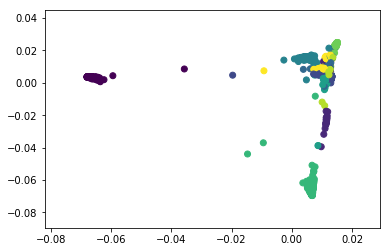

In [5]:
# coding:utf-8

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from mpl_toolkits.mplot3d import Axes3D

'''
author: heucoder
email: 812860165@qq.com
date: 2019.6.13
'''

def make_swiss_roll(n_samples=100, noise=0.0, random_state=None):
    #Generate a swiss roll dataset.
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))
    x = t * np.cos(t)
    y = 83 * np.random.rand(1, n_samples)
    z = t * np.sin(t)
    X = np.concatenate((x, y, z))
    X += noise * np.random.randn(3, n_samples)
    X = X.T
    t = np.squeeze(t)
    return X, t

def rbf(dist, t = 1.0):
    '''
    rbf kernel function
    '''
    return np.exp(-(dist/t))

def cal_pairwise_dist(x):

    '''计算pairwise 距离, x是matrix
    (a-b)^2 = a^2 + b^2 - 2*a*b
    '''
    sum_x = np.sum(np.square(x), 1)
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    #返回任意两个点之间距离的平方
    return dist

def cal_rbf_dist(data, n_neighbors = 10, t = 1):

    dist = cal_pairwise_dist(data)
    n = dist.shape[0]
    rbf_dist = rbf(dist, t)

    W = np.zeros((n, n))
    for i in range(n):
        index_ = np.argsort(dist[i])[1:1+n_neighbors]
        W[i, index_] = rbf_dist[i, index_]
        W[index_, i] = rbf_dist[index_, i]

    return W

def le(data,
          n_dims = 2,
          n_neighbors = 5, t = 1.0):
    '''

    :param data: (n_samples, n_features)
    :param n_dims: target dim
    :param n_neighbors: k nearest neighbors
    :param t: a param for rbf
    :return:
    '''
    N = data.shape[0]
    W = cal_rbf_dist(data, n_neighbors, t)
    D = np.zeros_like(W)
    for i in range(N):
        D[i,i] = np.sum(W[i])

    D_inv = np.linalg.inv(D)
    L = D - W
    eig_val, eig_vec = np.linalg.eig(np.dot(D_inv, L))

    sort_index_ = np.argsort(eig_val)

    eig_val = eig_val[sort_index_]
    print("eig_val[:10]: ", eig_val[:10])

    j = 0
    while eig_val[j] < 1e-6:
        j+=1

    print("j: ", j)

    sort_index_ = sort_index_[j:j+n_dims]
    eig_val_picked = eig_val[j:j+n_dims]
    print(eig_val_picked)
    eig_vec_picked = eig_vec[:, sort_index_]

    # print("L: ")
    # print(np.dot(np.dot(eig_vec_picked.T, L), eig_vec_picked))
    # print("D: ")
    # D not equal I ???
    print(np.dot(np.dot(eig_vec_picked.T, D), eig_vec_picked))

    X_ndim = eig_vec_picked
    return X_ndim

if __name__ == '__main__':
    # X, Y = make_swiss_roll(n_samples = 2000)
    # X_ndim = le(X, n_neighbors = 5, t = 20)
    #
    # fig = plt.figure(figsize=(12,6))
    # ax1 = fig.add_subplot(121, projection='3d')
    # ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c = Y)
    #
    # ax2 = fig.add_subplot(122)
    # ax2.scatter(X_ndim[:, 0], X_ndim[:, 1], c = Y)
    # plt.show()

    X = load_digits().data
    y = load_digits().target

    dist = cal_pairwise_dist(X)
    max_dist = np.max(dist)
    print("max_dist", max_dist)
    X_ndim = le(X, n_neighbors = 20, t = max_dist*0.1)
    plt.scatter(X_ndim[:, 0], X_ndim[:, 1], c = y)
    plt.show()


In [ ]:
# LPP

max_dist 5935.0
eig_val[:10] [0.         0.         0.         0.00174574 0.00860943 0.01745835
 0.02143826 0.03495575 0.04032973 0.04504305]
j:  3
[0.00174574 0.00860943]


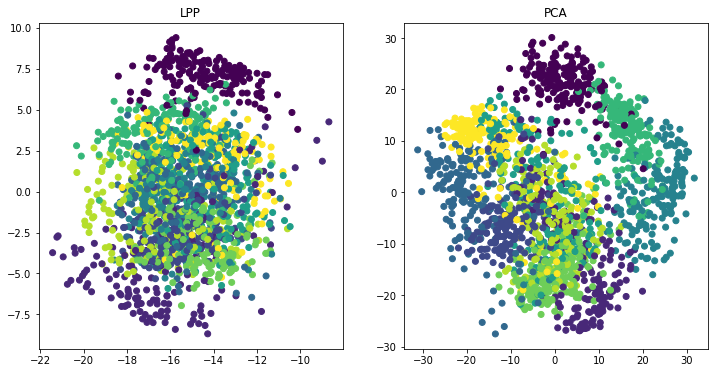

In [6]:
# coding:utf-8

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_digits, load_iris

'''
author: heucoder
email: 812860165@qq.com
date: 2019.6.13
'''

def make_swiss_roll(n_samples=100, noise=0.0, random_state=None):
    #Generate a swiss roll dataset.
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))
    x = t * np.cos(t)
    y = 83 * np.random.rand(1, n_samples)
    z = t * np.sin(t)
    X = np.concatenate((x, y, z))
    X += noise * np.random.randn(3, n_samples)
    X = X.T
    t = np.squeeze(t)
    return X, t

def rbf(dist, t = 1.0):
    '''
    rbf kernel function
    '''
    return np.exp(-(dist/t))

def cal_pairwise_dist(x):

    '''计算pairwise 距离, x是matrix
    (a-b)^2 = a^2 + b^2 - 2*a*b
    '''
    sum_x = np.sum(np.square(x), 1)
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    #返回任意两个点之间距离的平方
    return dist

def cal_rbf_dist(data, n_neighbors = 10, t = 1):

    dist = cal_pairwise_dist(data)
    n = dist.shape[0]
    rbf_dist = rbf(dist, t)

    W = np.zeros((n, n))
    for i in range(n):
        index_ = np.argsort(dist[i])[1:1 + n_neighbors]
        W[i, index_] = rbf_dist[i, index_]
        W[index_, i] = rbf_dist[index_, i]

    return W

def lpp(data,
        n_dims = 2,
        n_neighbors = 30, t = 1.0):
    '''

    :param data: (n_samples, n_features)
    :param n_dims: target dim
    :param n_neighbors: k nearest neighbors
    :param t: a param for rbf
    :return:
    '''
    N = data.shape[0]
    W = cal_rbf_dist(data, n_neighbors, t)
    D = np.zeros_like(W)

    for i in range(N):
        D[i,i] = np.sum(W[i])

    L = D - W
    XDXT = np.dot(np.dot(data.T, D), data)
    XLXT = np.dot(np.dot(data.T, L), data)

    eig_val, eig_vec = np.linalg.eig(np.dot(np.linalg.pinv(XDXT), XLXT))

    sort_index_ = np.argsort(np.abs(eig_val))
    eig_val = eig_val[sort_index_]
    print("eig_val[:10]", eig_val[:10])

    j = 0
    while eig_val[j] < 1e-6:
        j+=1

    print("j: ", j)

    sort_index_ = sort_index_[j:j+n_dims]
    # print(sort_index_)
    eig_val_picked = eig_val[j:j+n_dims]
    print(eig_val_picked)
    eig_vec_picked = eig_vec[:, sort_index_]

    data_ndim = np.dot(data, eig_vec_picked)

    return data_ndim

if __name__ == '__main__':
    X = load_digits().data
    y = load_digits().target
    # X, y = make_swiss_roll(n_samples = 1000)

    dist = cal_pairwise_dist(X)
    max_dist = np.max(dist)
    print("max_dist", max_dist)

    data_2d = lpp(X, n_neighbors = 5, t = 0.01*max_dist)
    data_2 = PCA(n_components=2).fit_transform(X)


    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.title("LPP")
    plt.scatter(data_2d[:, 0], data_2d[:, 1], c = y)

    plt.subplot(122)
    plt.title("PCA")
    plt.scatter(data_2[:, 0], data_2[:, 1], c = y)
    plt.show()



In [ ]:
# MDS

C:\anaconda\lib\site-packages\numpy\core\numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


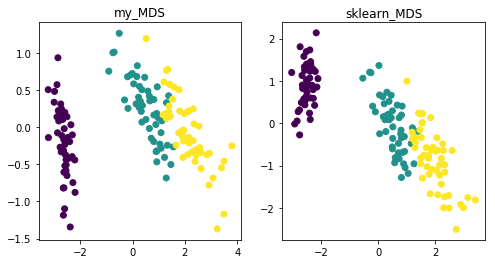

In [7]:
# coding:utf-8
import numpy as np
from sklearn.datasets import load_iris
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

'''
author: heucoder
email: 812860165@qq.com
date: 2019.6.13
'''

def cal_pairwise_dist(x):
    '''计算pairwise 距离, x是matrix
    (a-b)^2 = a^2 + b^2 - 2*a*b
    '''
    sum_x = np.sum(np.square(x), 1)
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    #返回任意两个点之间距离的平方
    return dist


def my_mds(data, n_dims):
    '''

    :param data: (n_samples, n_features)
    :param n_dims: target n_dims
    :return: (n_samples, n_dims)
    '''

    n, d = data.shape
    dist = cal_pairwise_dist(data)
    T1 = np.ones((n,n))*np.sum(dist)/n**2
    T2 = np.sum(dist, axis = 1, keepdims=True)/n
    T3 = np.sum(dist, axis = 0, keepdims=True)/n

    B = -(T1 - T2 - T3 + dist)/2

    eig_val, eig_vector = np.linalg.eig(B)
    index_ = np.argsort(-eig_val)[:n_dims]
    picked_eig_val = eig_val[index_].real
    picked_eig_vector = eig_vector[:, index_]
    # print(picked_eig_vector.shape, picked_eig_val.shape)
    return picked_eig_vector*picked_eig_val**(0.5)

if __name__ == '__main__':
    iris = load_iris()
    data = iris.data
    Y = iris.target
    data_1 = my_mds(data, 2)

    data_2 = MDS(n_components=2).fit_transform(data)

    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.title("my_MDS")
    plt.scatter(data_1[:, 0], data_1[:, 1], c=Y)

    plt.subplot(122)
    plt.title("sklearn_MDS")
    plt.scatter(data_2[:, 0], data_2[:, 1], c=Y)
    plt.savefig("MDS_1.png")
    plt.show()

In [ ]:
# PCA

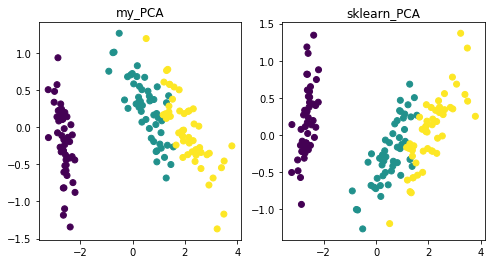

In [8]:
# coding:utf-8
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

'''
author: heucoder
email: 812860165@qq.com
date: 2019.6.13
'''

def pca(data, n_dim):
    '''

    pca is O(D^3)
    :param data: (n_samples, n_features(D))
    :param n_dim: target dimensions
    :return: (n_samples, n_dim)
    '''
    data = data - np.mean(data, axis = 0, keepdims = True)

    cov = np.dot(data.T, data)

    eig_values, eig_vector = np.linalg.eig(cov)
    # print(eig_values)
    indexs_ = np.argsort(-eig_values)[:n_dim]
    picked_eig_values = eig_values[indexs_]
    picked_eig_vector = eig_vector[:, indexs_]
    data_ndim = np.dot(data, picked_eig_vector)
    return data_ndim


# data 降维的矩阵(n_samples, n_features)
# n_dim 目标维度
# fit n_features >> n_samples, reduce cal
def highdim_pca(data, n_dim):
    '''

    when n_features(D) >> n_samples(N), highdim_pca is O(N^3)

    :param data: (n_samples, n_features)
    :param n_dim: target dimensions
    :return: (n_samples, n_dim)
    '''
    N = data.shape[0]
    data = data - np.mean(data, axis = 0, keepdims = True)

    Ncov = np.dot(data, data.T)

    Neig_values, Neig_vector = np.linalg.eig(Ncov)
    indexs_ = np.argsort(-Neig_values)[:n_dim]
    Npicked_eig_values = Neig_values[indexs_]
    # print(Npicked_eig_values)
    Npicked_eig_vector = Neig_vector[:, indexs_]
    # print(Npicked_eig_vector.shape)

    picked_eig_vector = np.dot(data.T, Npicked_eig_vector)
    picked_eig_vector = picked_eig_vector/(N*Npicked_eig_values.reshape(-1, n_dim))**0.5
    # print(picked_eig_vector.shape)

    data_ndim = np.dot(data, picked_eig_vector)
    return data_ndim

if __name__ == "__main__":
    data = load_iris()
    X = data.data
    Y = data.target
    data_2d1 = pca(X, 2)
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.title("my_PCA")
    plt.scatter(data_2d1[:, 0], data_2d1[:, 1], c = Y)

    sklearn_pca = PCA(n_components=2)
    data_2d2 = sklearn_pca.fit_transform(X)
    plt.subplot(122)
    plt.title("sklearn_PCA")
    plt.scatter(data_2d2[:, 0], data_2d2[:, 1], c = Y)
    plt.show()

In [ ]:
# KPCA

[5.84696253 5.58075796]


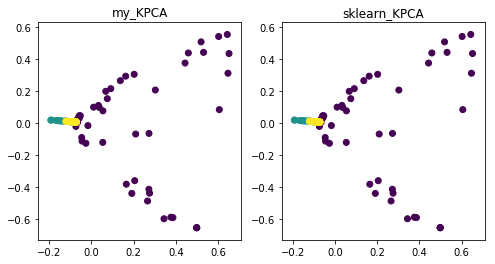

In [9]:
# coding:utf-8
# 实现KPCA

from sklearn.datasets import load_iris
from sklearn.decomposition import KernelPCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

'''
author: heucoder
email: 812860165@qq.com
date: 2019.6.13
'''


def sigmoid(x, coef = 0.25):
    x = np.dot(x, x.T)
    return np.tanh(coef*x+1)

def linear(x):
    x = np.dot(x, x.T)
    return x

def rbf(x, gamma = 15):
    sq_dists = pdist(x, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dists)
    return np.exp(-gamma*mat_sq_dists)

def kpca(data, n_dims=2, kernel = rbf):
    '''

    :param data: (n_samples, n_features)
    :param n_dims: target n_dims
    :param kernel: kernel functions
    :return: (n_samples, n_dims)
    '''

    K = kernel(data)
    #
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    #
    eig_values, eig_vector = np.linalg.eig(K)
    idx = eig_values.argsort()[::-1]
    eigval = eig_values[idx][:n_dims]
    eigvector = eig_vector[:, idx][:, :n_dims]
    print(eigval)
    eigval = eigval**(1/2)
    vi = eigvector/eigval.reshape(-1,n_dims)
    data_n = np.dot(K, vi)
    return data_n


if __name__ == "__main__":
    data = load_iris().data
    Y = load_iris().target
    data_1 = kpca(data, kernel=rbf)


    sklearn_kpca = KernelPCA(n_components=2, kernel="rbf", gamma=15)
    data_2 = sklearn_kpca.fit_transform(data)

    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.title("my_KPCA")
    plt.scatter(data_1[:, 0], data_1[:, 1], c = Y)

    plt.subplot(122)
    plt.title("sklearn_KPCA")
    plt.scatter(data_2[:, 0], data_2[:, 1], c = Y)
    plt.show()


In [ ]:
# SVD

In [11]:
# coding:utf-8

'''
author: heucoder
email: 812860165@qq.com
date: 2019.6.13
'''

import numpy as np
from sklearn.datasets import load_iris

def svd(data):
    '''
    :param data:
    :return: U, Sigma, VT
    '''

    # mean
    N, D = data.shape
    data = data - np.mean(data, axis=0)

    # V
    Veig_val, Veig_vector = np.linalg.eigh(np.dot(data.T, data))
    VT = Veig_vector[:, np.argsort(-abs(Veig_val))].T

    # U
    Ueig_val, Ueig_vector = np.linalg.eigh(np.dot(data, data.T))
    U = Ueig_vector[:, np.argsort(-abs(Ueig_val))]

    # Sigma
    Sigma = np.zeros((N, D))
    for i in range(D):
        Sigma[i, i] = np.dot(data, VT[i])[i]/U[i,i]

    return U, Sigma, VT

if __name__ == '__main__':
    iris = load_iris()
    X = iris.data
    Y = iris.target
    U, Sigma, VT = svd(X)



In [ ]:
# T-SNE

Computing pairwise distances...
Computing pair_prob for point 0 of 1797 ...
Computing pair_prob for point 500 of 1797 ...
Computing pair_prob for point 1000 of 1797 ...
Computing pair_prob for point 1500 of 1797 ...
Mean value of sigma:  11.698543429042957
T-SNE DURING:4.4624768174329335e-07
Iteration  100 : error is  13.007440599499583
Iteration  200 : error is  0.8795248234818023
ratio  0.06761705477368384
Iteration  300 : error is  0.7573072812477073
ratio  0.8610413953408744
Iteration  400 : error is  0.7192437065551013
ratio  0.9497382692136618
Iteration  500 : error is  0.7018331367508167
ratio  0.9757932260712097
finished training!


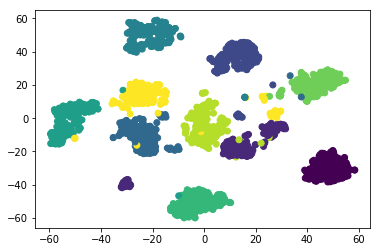

In [12]:
# coding:utf-8

import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import time

def cal_pairwise_dist(x):
    '''计算pairwise 距离, x是matrix
    (a-b)^2 = a^2 + b^2 - 2*a*b
    '''
    sum_x = np.sum(np.square(x), 1)
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    #返回任意两个点之间距离的平方
    return dist

def cal_perplexity(dist, idx=0, beta=1.0):
    '''计算perplexity, D是距离向量，
    idx指dist中自己与自己距离的位置，beta是高斯分布参数
    这里的perp仅计算了熵，方便计算
    '''
    prob = np.exp(-dist * beta)
    # 设置自身prob为0
    prob[idx] = 0
    sum_prob = np.sum(prob)
    if sum_prob < 1e-12:
        prob = np.maximum(prob, 1e-12)
        perp = -12
    else:
        perp = np.log(sum_prob) + beta * np.sum(dist * prob) / sum_prob
        prob /= sum_prob

    return perp, prob

def seach_prob(x, tol=1e-5, perplexity=30.0):
    '''二分搜索寻找beta,并计算pairwise的prob
    '''

    # 初始化参数
    print("Computing pairwise distances...")
    (n, d) = x.shape
    dist = cal_pairwise_dist(x)
    pair_prob = np.zeros((n, n))
    beta = np.ones((n, 1))
    # 取log，方便后续计算
    base_perp = np.log(perplexity)

    for i in range(n):
        if i % 500 == 0:
            print("Computing pair_prob for point %s of %s ..." %(i,n))

        betamin = -np.inf
        betamax = np.inf
        perp, this_prob = cal_perplexity(dist[i], i, beta[i])

        # 二分搜索,寻找最佳sigma下的prob
        perp_diff = perp - base_perp
        tries = 0
        while np.abs(perp_diff) > tol and tries < 50:
            if perp_diff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2
                else:
                    beta[i] = (beta[i] + betamin) / 2

            # 更新perb,prob值
            perp, this_prob = cal_perplexity(dist[i], i, beta[i])
            perp_diff = perp - base_perp
            tries = tries + 1
        # 记录prob值
        pair_prob[i,] = this_prob
    print("Mean value of sigma: ", np.mean(np.sqrt(1 / beta)))
    #每个点对其他点的条件概率分布pi\j
    return pair_prob

def tsne(x, no_dims=2, perplexity=30.0, max_iter=1000):
    """Runs t-SNE on the dataset in the NxD array x
    to reduce its dimensionality to no_dims dimensions.
    The syntaxis of the function is Y = tsne.tsne(x, no_dims, perplexity),
    where x is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array x should have type float.")
        return -1

    (n, d) = x.shape

    # 动量
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    # 随机初始化Y
    y = np.random.randn(n, no_dims)
    # dy梯度
    dy = np.zeros((n, no_dims))
    # iy是什么
    iy = np.zeros((n, no_dims))

    gains = np.ones((n, no_dims))

    # 对称化
    P = seach_prob(x, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)   #pij
    # early exaggeration
    # pi\j，提前夸大
    print ("T-SNE DURING:%s" % time.clock())
    P = P * 4
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):
        # Compute pairwise affinities
        sum_y = np.sum(np.square(y), 1)
        num = 1 / (1 + np.add(np.add(-2 * np.dot(y, y.T), sum_y).T, sum_y))
        num[range(n), range(n)] = 0
        Q = num / np.sum(num)   #qij
        Q = np.maximum(Q, 1e-12)    #X与Y逐位比较取其大者

        # Compute gradient
        # np.tile(A,N) 重复数组AN次 [1],5 [1,1,1,1,1]
        # pij-qij
        PQ = P - Q
        # 梯度dy
        for i in range(n):
            dy[i,:] = np.sum(np.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (y[i,:] - y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum

        gains = (gains + 0.2) * ((dy > 0) != (iy > 0)) + (gains * 0.8) * ((dy > 0) == (iy > 0))
        gains[gains < min_gain] = min_gain
        # 迭代
        iy = momentum * iy - eta * (gains * dy)
        y = y + iy
        y = y - np.tile(np.mean(y, 0), (n, 1))
        # Compute current value of cost function\
        if (iter + 1) % 100 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration ", (iter + 1), ": error is ", C)
            if (iter+1) != 100:
                ratio = C/oldC
                print("ratio ", ratio)
                if ratio >= 0.95:
                    break
            oldC = C
        # Stop lying about P-values
        if iter == 100:
            P = P / 4
    print("finished training!")
    return y

if __name__ == "__main__":
    digits = load_digits()
    X = digits.data
    Y = digits.target

    data_2d = tsne(X, 2)
    plt.scatter(data_2d[:, 0], data_2d[:, 1], c = Y)
    plt.show()
